# Model Statistics

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
STYLE_TRAIN, COLOR_TRAIN = "s-", "#19c"
STYLE_EVAL, COLOR_EVAL = "^-", "#f91"

## Data Loading

In [3]:
LOG_DIR = "20241003-193957"

In [4]:
df_statistics = pd.read_csv(
    f"../logs/{LOG_DIR}/statistics.csv",
    index_col=0,
)
df_statistics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   train_time_seconds  10 non-null     float64
 1   eval_time_seconds   10 non-null     float64
 2   epoch_time_seconds  10 non-null     float64
 3   train_avg_loss      10 non-null     float64
 4   eval_avg_loss       10 non-null     float64
 5   eval_accuracy       10 non-null     float64
dtypes: float64(6)
memory usage: 560.0 bytes


In [5]:
df_predictions = pd.read_csv(
    f"../logs/{LOG_DIR}/predictions.csv",
)
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   epoch         100000 non-null  int64
 1   prediction    100000 non-null  int64
 2   ground_truth  100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


## Training Time

In [6]:
train_times_in_seconds = df_statistics["train_time_seconds"]
total_train_times_in_seconds = train_times_in_seconds.sum()
mean_train_times_in_seconds = train_times_in_seconds.mean()
std_train_times_in_seconds = train_times_in_seconds.std()
print("Total Epoch(s)  : %23d" % len(df_statistics))
print(
    "Sum(TrainTime)  = %4.0f hr %3.0f min %3.0f sec"
    % (
        total_train_times_in_seconds // 3600,
        total_train_times_in_seconds // 60,
        total_train_times_in_seconds % 60,
    )
)
print(
    "Mean(TrainTime) = %4.0f hr %3.0f min %3.0f sec"
    % (
        mean_train_times_in_seconds // 3600,
        mean_train_times_in_seconds // 60,
        mean_train_times_in_seconds % 60,
    )
)
print(
    "Std(TrainTime)  = %4.0f hr %3.0f min %3.0f sec"
    % (
        std_train_times_in_seconds // 3600,
        std_train_times_in_seconds // 60,
        std_train_times_in_seconds % 60,
    )
)

Total Epoch(s)  :                      10
Sum(TrainTime)  =    0 hr   3 min  15 sec
Mean(TrainTime) =    0 hr   0 min  20 sec
Std(TrainTime)  =    0 hr   0 min   1 sec


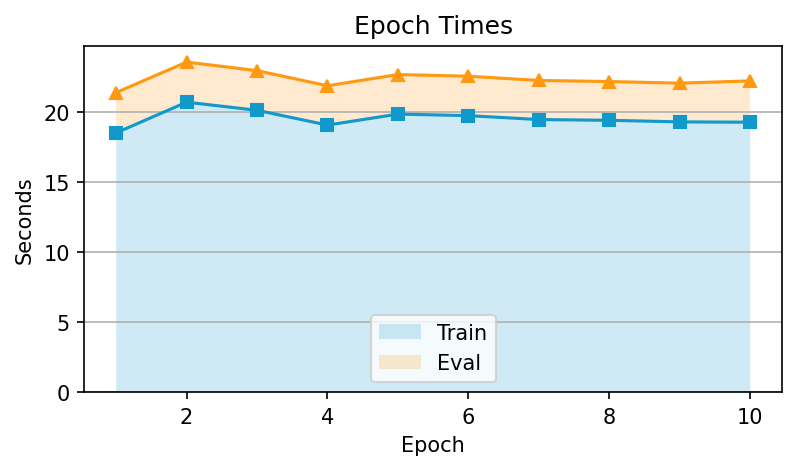

In [7]:

fig = plt.figure(figsize=(6, 3), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()
x_plot = df_statistics.index.to_numpy() + 1
ax.stackplot(
    x_plot,
    train_times_in_seconds,
    df_statistics["eval_time_seconds"],
    labels=("Train", "Eval"),
    colors=(COLOR_TRAIN, COLOR_EVAL),
    alpha=0.2,
)
ax.plot(
    x_plot,
    train_times_in_seconds,
    STYLE_TRAIN,
    color=COLOR_TRAIN,
)
ax.plot(
    x_plot,
    train_times_in_seconds + df_statistics["eval_time_seconds"],
    STYLE_EVAL,
    color=COLOR_EVAL,
)
ax.set(
    title="Epoch Times",
    xlabel="Epoch",
    ylabel="Seconds",
)
ax.legend()
ax.grid(axis="y")

## Accuracy & Loss

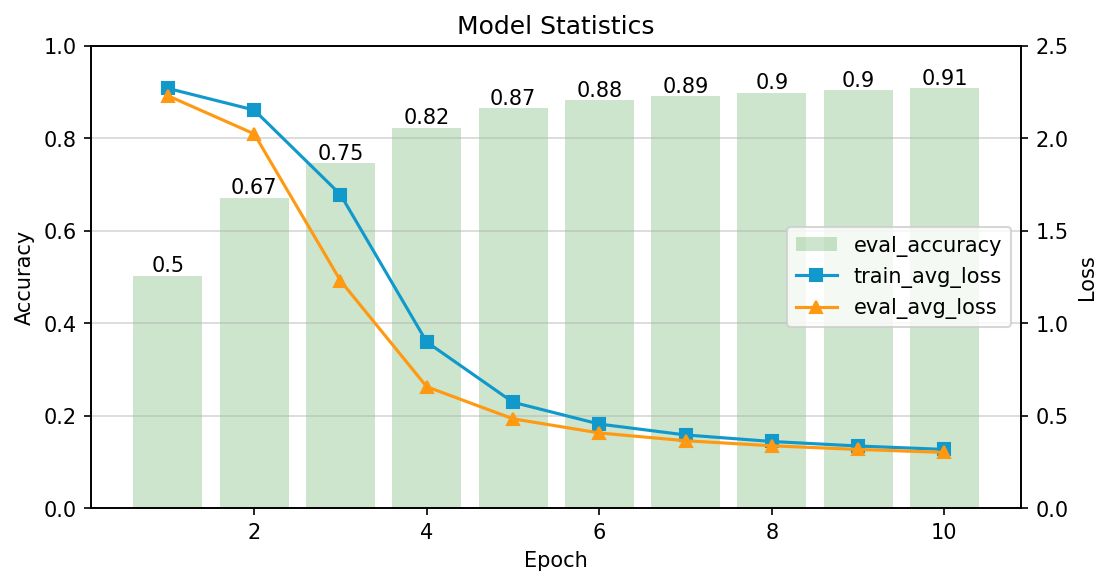

In [8]:
fig = plt.figure(figsize=(8, 4), dpi=150)
fig.set_facecolor("#fff")
ax_acc = fig.add_subplot()
ax_loss = ax_acc.twinx()

x = df_statistics.index.to_numpy() + 1

ax_loss.legend(
    handles=[
        bars := ax_acc.bar(
            x,
            df_statistics["eval_accuracy"],
            color="green",
            alpha=0.2,
            label="eval_accuracy",
        ),
        *ax_loss.plot(
            x,
            df_statistics["train_avg_loss"],
            STYLE_TRAIN,
            color=COLOR_TRAIN,
            label="train_avg_loss",
        ),
        *ax_loss.plot(
            x,
            df_statistics["eval_avg_loss"],
            STYLE_EVAL,
            color=COLOR_EVAL,
            label="eval_avg_loss",
        ),
    ],
    loc="center right",
)

for bar in bars:
    bar_height = bar.get_height()
    ax_acc.text(
        bar.get_x() + bar.get_width() / 2,
        bar_height,
        round(bar_height, 2),
        ha='center',
        va='bottom'
    )

ax_acc.set(
    ylabel="Accuracy",
    title="Model Statistics",
    xlabel="Epoch",
    ylim=(0, 1),
)
ax_loss.set(
    ylabel="Loss",
    ylim=(0, 2.5),
)
ax_acc.grid(axis="y", alpha=0.5)

## Confusion Matrix

prediction,0,1,2,3,4,5,6,7,8,9
ground_truth,,,,,,,,,,
0,0.94,0.00,0.00,0.03,0.00,0.00,0.01,0.00,0.01,0.00
1,0.00,0.96,0.01,0.01,0.00,0.00,0.01,0.00,0.02,0.00
2,0.03,0.00,0.75,0.11,0.02,0.00,0.03,0.02,0.05,0.00
3,0.01,0.01,0.02,0.88,0.00,0.02,0.01,0.02,0.04,0.01
4,0.01,0.00,0.00,0.02,0.81,0.00,0.03,0.02,0.01,0.10
5,0.04,0.01,0.00,0.18,0.04,0.59,0.02,0.01,0.05,0.01
6,0.03,0.01,0.02,0.04,0.01,0.02,0.85,0.00,0.01,0.00
7,0.00,0.02,0.02,0.04,0.01,0.00,0.00,0.82,0.01,0.08
8,0.02,0.02,0.01,0.13,0.01,0.02,0.01,0.03,0.71,0.03


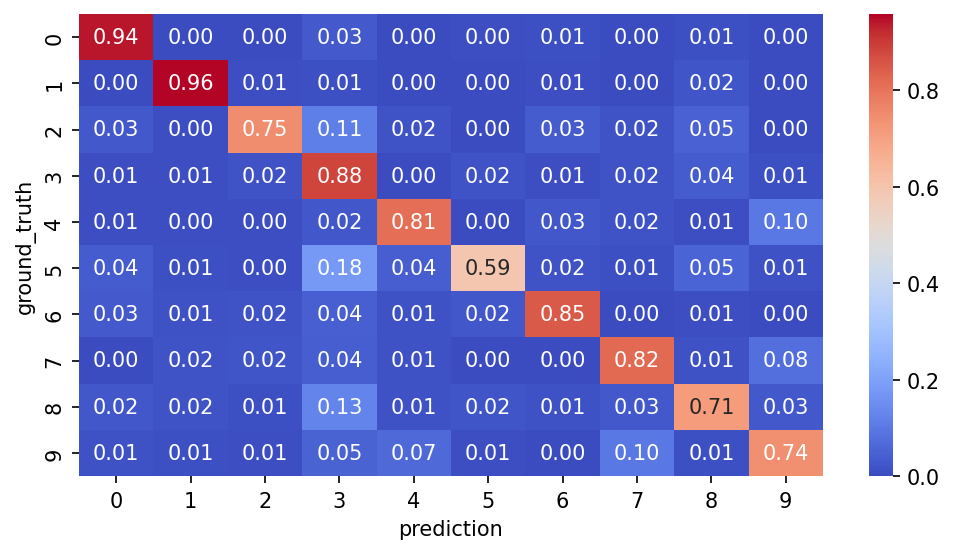

In [9]:
df_confusion_raw = df_predictions \
    .assign(count=1) \
    .pivot_table(
        values="count",
        index="ground_truth",
        columns="prediction",
        aggfunc="sum",
    ) \
    .fillna(0)
df_confusion = df_confusion_raw / df_confusion_raw.sum(axis=1)

fig = plt.figure(figsize=(8, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()
sns.heatmap(
    df_confusion,
    fmt=".2f",
    annot=True,
    cmap="coolwarm",
)

df_confusion.style.format("{:.2f}")